In [169]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np
import tracemalloc 

import json
import os
import glob
import pickle
from itertools import combinations
import gc
import time
import random

import warnings
warnings.filterwarnings("ignore")

In [170]:
DATA_ROOT = "../data/compgan_dataset/"

train_data_file_name_ = "train_data{}.npy"
train_label_file_name_ = "train_label{}.npy"
test_data_file_name_ = "test_data{}.npy"
test_label_file_name_ = "test_label{}.npy"

TRAIN_FOLDER_PATH = os.path.join(DATA_ROOT, "train")
TEST_FOLDER_PATH = os.path.join(DATA_ROOT, "test")
RESULT_FOLDER_PATH = os.path.join(DATA_ROOT, "results")

assert os.path.isdir(TRAIN_FOLDER_PATH) and os.path.isdir(TEST_FOLDER_PATH)
os.makedirs(RESULT_FOLDER_PATH, exist_ok=True)

data_files = sorted(glob.glob(os.path.join(TRAIN_FOLDER_PATH, train_data_file_name_.format("*"))))
print(data_files)
print(len(data_files))

['../data/compgan_dataset/train/train_data0.npy', '../data/compgan_dataset/train/train_data1.npy', '../data/compgan_dataset/train/train_data10.npy', '../data/compgan_dataset/train/train_data11.npy', '../data/compgan_dataset/train/train_data12.npy', '../data/compgan_dataset/train/train_data13.npy', '../data/compgan_dataset/train/train_data14.npy', '../data/compgan_dataset/train/train_data15.npy', '../data/compgan_dataset/train/train_data2.npy', '../data/compgan_dataset/train/train_data3.npy', '../data/compgan_dataset/train/train_data4.npy', '../data/compgan_dataset/train/train_data5.npy', '../data/compgan_dataset/train/train_data6.npy', '../data/compgan_dataset/train/train_data7.npy', '../data/compgan_dataset/train/train_data8.npy', '../data/compgan_dataset/train/train_data9.npy']
16


In [130]:
USER_NUM = 16
SENSOR_NUM = 7
EACH_SENSOR_CHANNEL = 6
assert USER_NUM == len(data_files)
feature_num = SENSOR_NUM * EACH_SENSOR_CHANNEL

In [131]:
# important

label_list = ['歩行(平地)',
 '歩行(階段)',
 'ベッド上での起き上がり',
 'ベッド椅子間の乗り移り(立つ)',
 'ベッド椅子間の乗り移り(立たない)',
 '立ち座り',
 '座位保持・座位バランス',
 '立位保持・立位バランス',
 '関節可動域増大訓練(肩)',
 '関節可動域増大訓練(股関節)']

label_dict = dict(enumerate(label_list))

In [132]:
# important
eng_label_dict = dict(zip(
    label_list,
    ['Walking', 'Upstair', 'Bed_Standup', 'Change_Bed', 'Change_Bed_Standup', 'Sit_Down', 'Sit', 'Stand', 'Shoulder_Exercise', 'Hip_Exercise']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

In [133]:
class CustomTrainDataset(Dataset):
    TRAIN_MODE = "train"
    TEST_MODE = "test"
    
    def __init__(self, mode, feature_data, label_data, missing_sensor_numbers=0):
        self.mode = mode
        assert mode in [self.TRAIN_MODE, self.TEST_MODE]
        
        self.features = feature_data
        self.label = label_data
        assert len(self.features) == len(self.label), "features len is not equal to label len"
        self.missing_sensor_numbers = missing_sensor_numbers

        self.missing_index_list = []
        for missing_count in range(missing_sensor_numbers + 1):
            for missing_index in combinations(range(SENSOR_NUM), missing_count):
                self.missing_index_list.append(missing_index)

    def transform(self, one_feature, missing_sensor_id_list):
        # Make one sensor data become 0
        one_feature_cp = one_feature.copy()
        
        for missing_sensor_id in missing_sensor_id_list:
            one_feature_cp[:, missing_sensor_id*6:(missing_sensor_id+1)*6] = 0
        return one_feature_cp
        
    def __len__(self):
        if self.mode == self.TRAIN_MODE:
            # although the transform generate more data, the index here is irrelevant
            return len(self.features)
        else:
            # take all available missing pattern * data number
            return len(self.features) * len(self.missing_index_list)
    
    def __getitem__(self, idx):
        if self.mode == self.TRAIN_MODE:
            missing_sensor_id_list = random.choice(self.missing_index_list)
            x = self.transform(self.features[idx], missing_sensor_id_list)
            label = self.label[idx]

        else:
            # take all available missing pattern
            missing_sensor_id_list = self.missing_index_list[ idx // len(self.features) ]
            x = self.transform(self.features[ idx % len(self.features) ], missing_sensor_id_list)
            label = self.label[idx % len(self.features)]
        return x, int(label)


In [189]:
class DataModule(pl.LightningDataModule):
    STANDARDIZE = False
    BATCH_SIZE = 512
    
    def __init__(self, test_user, missing_sensor_numbers):
        super().__init__()
        self.test_user = test_user
        self.missing_sensor_numbers = missing_sensor_numbers

    def load_data(self, mode):
        if mode == "train":
            folder_path = TRAIN_FOLDER_PATH
            data_file_name = train_data_file_name_
            label_file_name = train_label_file_name_

            train_val_data_list = None
            train_val_label_list = None
            
            for user in range(USER_NUM):
                if user == self.test_user: 
                    continue
                
                print("train_user", user)
                train_data_file_name = data_file_name.format(user)
                train_label_file_name = label_file_name.format(user)

                train_data_file_path = os.path.join(folder_path, train_data_file_name)
                train_label_file_path = os.path.join(folder_path, train_label_file_name)
                
                train_val_data, train_val_label = np.load(train_data_file_path), np.load(train_label_file_path)
                l, s, d, w = train_val_data.shape
                train_val_data = train_val_data.reshape(l, s * d, w).transpose(0,2,1)

                if train_val_data_list is None:
                    train_val_data_list = train_val_data
                    train_val_label_list = train_val_label
                else:
                    train_val_data_list = np.vstack((train_val_data_list, train_val_data))
                    train_val_label_list = np.concatenate((train_val_label_list, train_val_label))

            train_val_data = train_val_data_list
            train_val_label = train_val_label_list
            
        elif mode == "test":
            folder_path = TEST_FOLDER_PATH
            data_file_name = test_data_file_name_
            label_file_name = test_label_file_name_
    
            train_data_file_name = data_file_name.format(self.test_user)
            train_label_file_name = label_file_name.format(self.test_user)
    
            train_data_file_path = os.path.join(folder_path, train_data_file_name)
            train_label_file_path = os.path.join(folder_path, train_label_file_name)
            train_val_data, train_val_label = np.load(train_data_file_path), np.load(train_label_file_path)
            l, s, d, w = train_val_data.shape
            train_val_data = train_val_data.reshape(l, s * d, w).transpose(0,2,1)
    
        return train_val_data, train_val_label

    def setup(self, stage: str):
        # Assign Train/val split(s) for use in Dataloaders
        
        if stage == "validate" or stage == "fit":
            train_val_data, train_val_label = self.load_data("train")
            self.train_data, self.val_data, self.train_label, self.val_label = train_test_split(
                train_val_data, train_val_label, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)

            self.train_dataset = CustomTrainDataset(
                CustomTrainDataset.TRAIN_MODE, self.train_data, self.train_label, missing_sensor_numbers=self.missing_sensor_numbers)
            self.val_dataset = CustomTrainDataset(
                CustomTrainDataset.TEST_MODE, self.val_data, self.val_label, missing_sensor_numbers=self.missing_sensor_numbers)

        elif stage == "test" or stage == "predict":
            train_val_data, train_val_label = self.load_data("test")
            self.test_data = train_val_data
            self.test_label = train_val_label

            self.test_dataset = CustomTrainDataset(
                CustomTrainDataset.TEST_MODE, self.test_data, self.test_label, missing_sensor_numbers=self.missing_sensor_numbers)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.BATCH_SIZE, num_workers=0, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.BATCH_SIZE,  num_workers=0, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.BATCH_SIZE,  num_workers=0, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.BATCH_SIZE,  num_workers=0, shuffle=False)

    def teardown(self, stage):
        print("teardown")
        if stage == "validate" or stage == "fit":
            del self.train_data, self.train_label
            del self.val_data, self.val_label
            del self.train_dataset
            del self.val_dataset
            
        elif stage == "test" or stage == "predict":
            del self.test_data, self.test_label
            del self.test_dataset
        gc.collect()


In [164]:
data_module = DataModule(0,0)
data_module.setup("test")
# print(data_module.train_data.shape)
# print(data_module.val_data.shape)
print(data_module.test_data.shape)

(214, 256, 42)


In [168]:
data_number = 0

for i in range(16):
    data_module = DataModule(i,1)
    data_module.setup("test")
    data_number += data_module.test_data.shape[0]

data_number

6575

In [136]:
data = data_module.val_dataset[1254 * 7 + 1]
data[1], data[0][0]

(5,
 array([0.52302855, 0.45862108, 0.4819528 , 0.35954475, 0.4063701 ,
        0.42080292, 0.49819058, 0.5347038 , 0.5414914 , 0.44987702,
        0.4163005 , 0.4034852 , 0.5110033 , 0.4422083 , 0.51816595,
        0.4188102 , 0.4173594 , 0.4163255 , 0.5352975 , 0.49976563,
        0.5127471 , 0.4029349 , 0.5155876 , 0.4181098 , 0.5546729 ,
        0.5013719 , 0.50698453, 0.39465544, 0.50460666, 0.41684246,
        0.5664106 , 0.4982656 , 0.49760932, 0.4180848 , 0.41712594,
        0.41787636, 0.56169176, 0.5168847 , 0.50617826, 0.4175345 ,
        0.41721767, 0.4175095 ], dtype=float32))

In [137]:
del data_module, data
gc.collect()

1431

## MODEL DEFINITION

In [138]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [222]:

class LSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=42, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 256, input_size)
        
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=3,
                          batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)

        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, _ = self.rnn(x)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

        self.all_pred = test_pred_labels
        self.all_test = y

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [245]:
class LSTMBiModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=42, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 256, input_size)
        
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=3,
                          batch_first=True,
                          bidirectional=True)

        double_hidden_size = hidden_size * 2
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=double_hidden_size, out_features=double_hidden_size),
            nn.BatchNorm1d(num_features=double_hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * double_hidden_size, out_features=output_size)

        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, (h, _) = self.rnn(x)
        b, _, _ = activation.size()
        
        lstm_output = h[-2:].permute(1,0,2).reshape(b, -1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

        self.all_pred = test_pred_labels
        self.all_test = y

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [246]:
class LSTMAttentionModel(pl.LightningModule):
    def __init__(self, hidden_size=128, input_size=42, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 256, input_size)
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )

        self.rnn3 = nn.LSTM(input_size=hidden_size, 
                  hidden_size=hidden_size,
                  num_layers=1,
                  batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, _ = self.rnn1(x)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)
        activation, (h, _) = self.rnn3(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
        self.all_pred = test_pred_labels
        self.all_test = y
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [247]:

class CNNLSTMModel(pl.LightningModule):
    def __init__(self, hidden_size=128, sequence_length=256, input_size=42, cnn_filter_size=64, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, sequence_length, input_size)
        
        self.cnn = nn.Conv1d(sequence_length, cnn_filter_size, kernel_size=5, padding="same")
        
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=3,
                          batch_first=True)
 
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)

        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        output = self.cnn(x)
        activation, _ = self.rnn(output)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

        self.all_pred = test_pred_labels
        self.all_test = y

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [248]:
class CNNLSTMAttentionModel(pl.LightningModule):
    def __init__(self, hidden_size=128, sequence_length=256, input_size=42, cnn_filter_size=64, output_size=10, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, sequence_length, input_size)
        
        self.cnn = nn.Conv1d(sequence_length, cnn_filter_size, kernel_size=5, padding="same")
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )

        self.rnn3 = nn.LSTM(input_size=hidden_size, 
                  hidden_size=hidden_size,
                  num_layers=1,
                  batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        output = self.cnn(x)
        activation, _ = self.rnn1(output)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)
        activation, _ = self.rnn3(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
        self.all_pred = test_pred_labels
        self.all_test = y
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        
        test_pred_logits = self.forward(X)
        test_pred_labels = test_pred_logits.argmax(dim=1)
        
        return test_pred_labels
        

In [249]:
train_model_class = [LSTMModel, LSTMBiModel, LSTMAttentionModel, CNNLSTMModel, CNNLSTMAttentionModel]


In [21]:
# only for test

def test():
    patience = 20
    missing_sensor_numbers = 4 # no missing sensor
    user = 2 # use user2 to test
    for model_class in train_model_class:
        data_module = DataModule(test_user=user, missing_sensor_numbers=missing_sensor_numbers)
        
        model = model_class(input_size=42, output_size=10)
        
        model_name = model.__class__.__name__
        print("Running for model", model_name)
        print("summary(model)", summary(model))

        tb_logger = TensorBoardLogger(f"./loggers/{model_name}")
        
        trainer = pl.Trainer(
            logger=tb_logger,
            callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
            fast_dev_run = True
        )
        trainer.fit(model, data_module)
        trainer.test(model, data_module)
# test()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Running for model LSTMModel
summary(model) =================================================================
Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              352,256
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─BatchNorm1d: 2-2                  256
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       16,512
│    └─BatchNorm1d: 2-6                  256
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d: 2-14                 256
│    └─Dropout1d: 2-15   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | In sizes        | Out sizes                                           
-------------------------------------------------------------------------------------------------------------------
0 | rnn        | LSTM       | 352 K  | [1024, 256, 42] | [[1024, 256, 128], [[3, 1024, 128], [3, 1024, 128]]]
1 | seq_1      | Sequential | 33.5 K | [1024, 128]     | [1024, 128]                                         
2 | seq_2      | Sequential | 33.5 K | [1024, 128]     | [1024, 128]                                         
3 | classifier | Linear     | 3.9 K  | [1024, 384]     | [1024, 10]                                          
-------------------------------------------------------------------------------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.693     Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.63it/s]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s]
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                0.275390625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown
Running for model LSTMBiModel
summary(model) =================================================================
Layer (type:depth-idx)                   Param #
LSTMBiModel                              --
├─LSTM: 1-1                              966,656
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       65,792
│    └─BatchNorm1d: 2-2                  512
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       65,792
│    └─BatchN

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | In sizes        | Out sizes                                           
-------------------------------------------------------------------------------------------------------------------
0 | rnn        | LSTM       | 966 K  | [1024, 256, 42] | [[1024, 256, 256], [[6, 1024, 128], [6, 1024, 128]]]
1 | seq_1      | Sequential | 132 K  | [1024, 256]     | [1024, 256]                                         
2 | seq_2      | Sequential | 132 K  | [1024, 256]     | [1024, 256]                                         
3 | classifier | Linear     | 7.7 K  | [1024, 768]     | [1024, 10]                                          
-------------------------------------------------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.958     Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                0.185546875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Running for model LSTMAttentionModel
summary(model) =================================================================
Layer (type:depth-idx)                   Param #
LSTMAttentionModel                       --
├─LSTM: 1-1                              88,064
├─SelfAttention: 1-2                     --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Softmax: 2-4                      --
├─LSTM: 1-3                              132,096
├─SelfAttention: 1-4                     --
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       16,512
│    └─Softmax: 2-8                      --
├─LSTM: 1-5                              132,096
├─Sequential: 1-6                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   -

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes         | Out sizes                                           
-----------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 88.1 K | [1024, 256, 42]  | [[1024, 256, 128], [[1, 1024, 128], [1, 1024, 128]]]
1 | attention1 | SelfAttention | 49.5 K | [1024, 256, 128] | [1024, 256, 128]                                    
2 | rnn2       | LSTM          | 132 K  | [1024, 256, 128] | [[1024, 256, 128], [[1, 1024, 128], [1, 1024, 128]]]
3 | attention2 | SelfAttention | 49.5 K | [1024, 256, 128] | [1024, 256, 128]                                    
4 | rnn3       | LSTM          | 132 K  | [1024, 256, 128] | [[1024, 256, 128], [[1, 1024, 128], [1, 1024, 128]]]
5 | seq_1      | Sequential    | 33.5 K | [1024, 128]      | [1024, 128]                                         
6 | seq_2      | Sequential    | 33.5 K

Epoch 0: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s, train_loss=2.360]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s, train_loss=2.360, val_loss=2.300]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s, train_loss=2.360, val_loss=2.300]
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                0.052734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Running for model CNNLSTMModel
summary(model) =================================================================
Layer (type:depth-idx)                   Param #
CNNLSTMModel                             --
├─Conv1d: 1-1                            81,984
├─LSTM: 1-2                              352,256
├─Sequential: 1-3                        --
│    └─Linear: 2-1                       16,512
│    └─BatchNorm1d: 2-2                  256
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       16,512
│    └─BatchNorm1d: 2-6                  256
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | In sizes        | Out sizes                                          
------------------------------------------------------------------------------------------------------------------
0 | cnn        | Conv1d     | 82.0 K | [1024, 256, 42] | [1024, 64, 42]                                     
1 | rnn        | LSTM       | 352 K  | [1024, 64, 42]  | [[1024, 64, 128], [[3, 1024, 128], [3, 1024, 128]]]
2 | seq_1      | Sequential | 33.5 K | [1024, 128]     | [1024, 128]                                        
3 | seq_2      | Sequential | 33.5 K | [1024, 128]     | [1024, 128]                                        
4 | classifier | Linear     | 3.9 K  | [1024, 384]     | [1024, 10]                                         
------------------------------------------------------------------------------------------------------------------
505 K     Trainable params
0         Non-trainable params
505 K     Total

Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


teardown
Running for model CNNLSTMAttentionModel
summary(model) =================================================================
Layer (type:depth-idx)                   Param #
CNNLSTMAttentionModel                    --
├─Conv1d: 1-1                            81,984
├─LSTM: 1-2                              88,064
├─SelfAttention: 1-3                     --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Softmax: 2-4                      --
├─LSTM: 1-4                              132,096
├─SelfAttention: 1-5                     --
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       16,512
│    └─Softmax: 2-8                      --
├─LSTM: 1-6                              132,096
├─Sequential: 1-7                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes        | Out sizes                                          
---------------------------------------------------------------------------------------------------------------------
0 | cnn        | Conv1d        | 82.0 K | [1024, 256, 42] | [1024, 64, 42]                                     
1 | rnn1       | LSTM          | 88.1 K | [1024, 64, 42]  | [[1024, 64, 128], [[1, 1024, 128], [1, 1024, 128]]]
2 | attention1 | SelfAttention | 49.5 K | [1024, 64, 128] | [1024, 64, 128]                                    
3 | rnn2       | LSTM          | 132 K  | [1024, 64, 128] | [[1024, 64, 128], [[1, 1024, 128], [1, 1024, 128]]]
4 | attention2 | SelfAttention | 49.5 K | [1024, 64, 128] | [1024, 64, 128]                                    
5 | rnn3       | LSTM          | 132 K  | [1024, 64, 128] | [[1024, 64, 128], [[1, 1024, 128], [1, 1024, 128]]]
6 | seq_1      | Sequential    | 33.5 K | [1024, 128]  

Epoch 0: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.48it/s, train_loss=2.320]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████| 1/1 [00:00<00:00, 10.90it/s, train_loss=2.320, val_loss=2.300]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s, train_loss=2.320, val_loss=2.300]
teardown


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                0.275390625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
teardown


In [ ]:
batch_size = 512
patience = 20
# missing_sensor_numbers = 0
# all_test_pred = {}

for missing_sensor_numbers in [1]: ## Changed for 1 missing sensor
    for user in range(USER_NUM): ## Changed for user 2 only
        for model_class in train_model_class: 
            start_timer = time.perf_counter()
            
            all_test = []
            all_pred = []
            print(f"\n*************training on User{user}*************")
            
            data_module = DataModule(test_user=user, missing_sensor_numbers=missing_sensor_numbers)
            
            model = model_class(input_size=42, output_size=10)
            model_name = model.__class__.__name__
            print("Running for model", model_name)
            
            tb_logger = TensorBoardLogger(f"./logger96_{missing_sensor_numbers}missing/{model_name}")
            
            trainer = pl.Trainer(
                logger=tb_logger,
                callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
            )
        
            trainer.fit(model, data_module)
            trainer.test(model, data_module)
    
            all_test.extend(model.all_test)
            all_pred.extend(model.all_pred)
    
            test_target_pred = (all_test, all_pred)
            
            end_timer = time.perf_counter()
            exec_time = end_timer - start_timer

            save_dir = os.path.join(RESULT_FOLDER_PATH, f"96_{missing_sensor_numbers}missing")
            os.makedirs(save_dir, exist_ok=True)
            with open(os.path.join(save_dir, f"test_pred_user_{user}_{missing_sensor_numbers}_{model_name}_{exec_time:.0f}s.pkl"), "wb") as f:
                pickle.dump(test_target_pred, f)



## Calculate the performance of the model

Because the size is not valid this result must be verified

In [276]:
# missing_sensor_numbers = 1
# model_name = train_model_class[2].__name__
# print(model_name)

# all_test_pred = {}
# for user in range(USER_NUM):
#     files = glob.glob(os.path.join(RESULT_FOLDER_PATH, f"96_{missing_sensor_numbers}missing", f"test_pred_user_{user}_{missing_sensor_numbers}_{model_name}_*s.pkl"))
#     assert len(files) == 1
#     with open(files[0], "rb") as f:
#         all_test_pred[user] = pickle.load(f)

In [277]:
# all_test_pred_result = ([], [])
# for user in range(USER_NUM):
#     all_test_pred_result[0].extend(all_test_pred[user][0])
#     all_test_pred_result[1].extend(all_test_pred[user][1])

# print(len(all_test_pred_result[0]))

In [278]:
# all_test, all_pred = all_test_pred_result

# # print("missing index", missing_index)
# all_test_with_label = [label_list[i] for i in all_test]
# all_pred_with_label = [label_list[i] for i in all_pred]

# cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
# sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [279]:
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# all_test_cpu = list(map(lambda x: x.cpu().item(), all_test))
# all_pred_cpu = list(map(lambda x: x.cpu().item(), all_pred))

# print("accuracy:", accuracy_score(all_test_cpu, all_pred_cpu))
# print("precision_score", precision_score(all_test_cpu, all_pred_cpu, average="macro"))
# print("recall_score", recall_score(all_test_cpu, all_pred_cpu, average="macro"))
# print("F1 score:", f1_score(all_test_cpu, all_pred_cpu, average="macro"))

In [281]:
from collections import defaultdict
missing_sensor_numbers = 1
all_time_dict = defaultdict(list)

for one_model_class in train_model_class:
    model_name = one_model_class.__name__
    
    for user in range(USER_NUM):
        
        files = glob.glob(os.path.join(RESULT_FOLDER_PATH, f"96_{missing_sensor_numbers}missing", f"test_pred_user_{user}_{missing_sensor_numbers}_{model_name}_*s.pkl"))
        assert len(files) == 1
        file = files[0]
        
        exec_time = float(os.path.basename(file).split("_")[-1].split("s")[0])
        # print("exec_time", exec_time)
        all_time_dict[model_name].append(exec_time)

for model_name, exec_time_list in all_time_dict.items():
    print(model_name, np.average(exec_time_list))



LSTMModel 2667.3125
LSTMBiModel 6618.125
LSTMAttentionModel 4516.9375
CNNLSTMModel 1079.125
CNNLSTMAttentionModel 1437.0625


## Predict full length

In [288]:
batch_size = 512
patience = 20

all_test_pred = {}

for missing_sensor_numbers in [1]: ## Changed for 1 missing sensor
    all_test_pred[missing_sensor_numbers] = {}
    
    for model_class in train_model_class: 
        all_user_y_true = []
        all_user_y_pred = []
        
        for user in range(16): ## Changed for user 2 only
            model_name = model_class.__name__

            checkpoint_path = f"./logger96_{missing_sensor_numbers}missing/{model_name}/lightning_logs/version_{user}/checkpoints/*.ckpt"
            checkpoint_glob = glob.glob(checkpoint_path)
            assert len(checkpoint_glob) == 1, checkpoint_path
            checkpoint_file = checkpoint_glob[0]

            assert os.path.exists(checkpoint_file), checkpoint_file
            model = model_class.load_from_checkpoint(checkpoint_file)

            data_module = DataModule(test_user=user, missing_sensor_numbers=missing_sensor_numbers)
            data_module.setup("test")
            test_loader = data_module.test_dataloader()
            
            tb_logger = TensorBoardLogger(f"./logger96_{missing_sensor_numbers}missing/result_test")
            trainer = pl.Trainer(logger=tb_logger,)

            pred = trainer.predict(model, test_loader)

            y_true_list = []
            for batch_idx, test_data in enumerate(test_loader):
                _, y_true = test_data
                y_true_list.append(y_true)

            all_user_y_true.append(torch.cat(y_true_list))
            all_user_y_pred.append(torch.cat(pred))

        all_test_pred[missing_sensor_numbers][model_name] = (torch.cat(all_user_y_true), torch.cat(all_user_y_pred))
        
        print("model_name", model_name)
        all_test_cpu = list(map(lambda x: x.cpu().item(), torch.cat(all_user_y_true)))
        all_pred_cpu = list(map(lambda x: x.cpu().item(), torch.cat(all_user_y_pred)))
        
        print("accuracy", accuracy_score(all_test_cpu, all_pred_cpu))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.22it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.40it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 23.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 23.67it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 13/13 [00:00<00:00, 23.76it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 23.49it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 24.16it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.24it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.14it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.68it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.17it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.68it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 29.61it/s]
model_name LSTMModel
accuracy 0.679828897338403


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.53it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:01<00:00, 12.25it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:01<00:00, 12.29it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 13/13 [00:01<00:00, 12.29it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:01<00:00, 12.19it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:01<00:00, 12.66it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.62it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.94it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.23it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.63it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.63it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.16it/s]
model_name LSTMBiModel


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


accuracy 0.9930988593155894
Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.09it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.49it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 16.79it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 16.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 13/13 [00:00<00:00, 16.88it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 16.67it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 17.33it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.67it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.15it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.55it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.22it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.38it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.27it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.31it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.07it/s]
model_name LSTMAttentionModel


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


accuracy 0.9669011406844107
Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 63.06it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.77it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 49.54it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 49.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 13/13 [00:00<00:00, 49.95it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 49.28it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 51.21it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 82.89it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 84.66it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 74.50it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 59.69it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 65.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 66.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 69.90it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 64.61it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 67.02it/s]
model_name CNNLSTMModel


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


accuracy 0.9961216730038023
Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 42.28it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 42.43it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 13/13 [00:00<00:00, 42.64it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 41.74it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 43.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 68.06it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 69.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 61.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 50.01it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 53.40it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 54.98it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 58.60it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 53.86it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 56.04it/s]
model_name CNNLSTMAttentionModel
accuracy 0.9962737642585552


In [285]:
all_test_pred

{0: {'LSTMAttentionModel': (tensor([0, 0, 0,  ..., 9, 9, 9]),
   tensor([2, 2, 2,  ..., 2, 2, 2]))}}

LSTMAttentionModel


<Axes: >

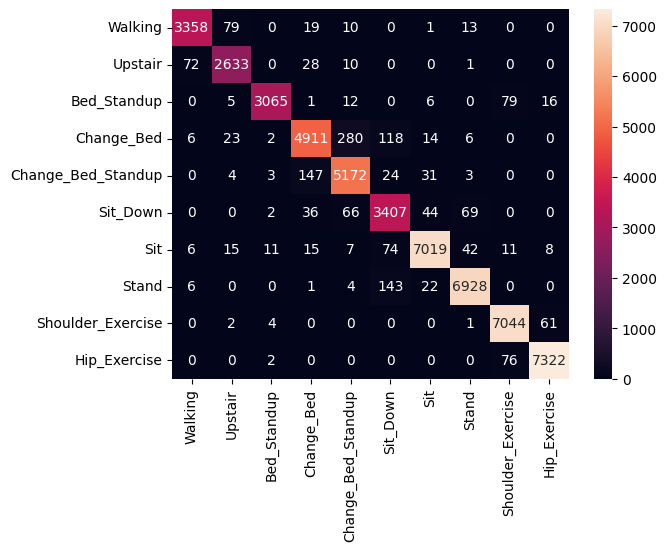

In [289]:
missing_sensor_numbers = 1
model_name = train_model_class[2].__name__
print(model_name)

all_test, all_pred = all_test_pred[missing_sensor_numbers][model_name]

# print("missing index", missing_index)
all_test_with_label = [label_list[i] for i in all_test]
all_pred_with_label = [label_list[i] for i in all_pred]

cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [290]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

all_test_cpu = list(map(lambda x: x.cpu().item(), all_test))
all_pred_cpu = list(map(lambda x: x.cpu().item(), all_pred))

print("accuracy:", accuracy_score(all_test_cpu, all_pred_cpu))
print("precision_score", precision_score(all_test_cpu, all_pred_cpu, average="macro"))
print("recall_score", recall_score(all_test_cpu, all_pred_cpu, average="macro"))
print("F1 score:", f1_score(all_test_cpu, all_pred_cpu, average="macro"))

accuracy: 0.9669011406844107
precision_score 0.9636457102663731
recall_score 0.9632995603385173
F1 score: 0.9633461573000803
